This notebook was created for the study of a galaxy Seyfert Type II.

In [1]:
from astro_constants import *
from source_parameters import *
from rates import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy import units as u
from astropy import constants as const
from scipy.stats import chisquare
from scipy.optimize import curve_fit

Defining our source

In [3]:
## Initialize the class
coronal_data = Coronal_Description(r_x, l, l_x, mdot, m)

## Calculate parameters for emission region
B_c = coronal_data.coronal_mag_field()
n_c = coronal_data.coronal_density()
T_c = coronal_data.coronal_temperature()
delta_RX = coronal_data.width_current_sheet()
wdot_B = coronal_data.mag_rec_power()

print(f'\nCoronal Magnetic Field:\n B_c = {B_c:.4E} G')
print(f'\nCoronal Particle Number Density:\n n_c = {n_c:.4E} cm-3')
print(f'\nCoronal Temperature:\n T_c = {T_c:.4E} K')
print(f'\nWidth of the current sheet:\n delta_RX = {delta_RX:.4E} cm')
print(f'\nReconnection Power:\n wdot_B = {wdot_B:.4E} erg s-1')


Coronal Magnetic Field:
 B_c = 1.9843E+04 G

Coronal Particle Number Density:
 n_c = 5.1761E+10 cm-3

Coronal Temperature:
 T_c = 3.1016E+09 K

Width of the current sheet:
 delta_RX = 4.2860E+10 cm

Reconnection Power:
 wdot_B = 5.1226E+42 erg s-1


In [5]:
# erg = 1.602177e-12 # [1 eV = 1.6022e-12 erg]

Ep = np.linspace(1e9, 1e16)*eV # Energy range [erg]

rho = n_c * mp # [g cm-3] fluid density

In [6]:
E_norm = Ep / (mp*c**2)

In [7]:
# E_norm

In [8]:
v_a0 = B_c / np.sqrt(4 * np.pi * rho)

va = v_a0 * coronal_data.Gamma

va/c

0.44871560804816396

In [9]:
r_c = 10 * R_s  # [cm] coronal size
L_x = 7 * 10**43 # [erg s-1]
epsilon_0 = 7*keV # [erg] compton hump energy

U_x = L_x / (4 * np.pi * c * r_c**2)

In [10]:
n_x = U_x * ( epsilon_0**(-2) * (20*keV - 1*keV) + ( -(200*keV)**(-1) + (20*keV)**(-1) ) )

In [11]:
print(f'\nPhoton field Energy Density for X-rays = {n_x:.5E} cm-3')


Photon field Energy Density for X-rays = 1.43205E+13 cm-3


In [36]:
def timeacc_fermi(E):
    '''Eq.(2.37) of Medina-Torrejon Thesis'''
    alpha = 0.1
    s = 1/alpha
    E0 = 10**(4)
    t0 = 700
    ## hours
    return s**(-1) * (E0/E)**(-1/s) * t0
    # return (E0/E)**(-1/s) * t0


def time_acc_regime3(va, delta_RX):
    v_in = 0.05 * va
    beta_in = v_in / c
    d_ur = 2 * beta_in * ( 3 * beta_in**2 + 3*beta_in + 1 ) / ( 3 * (beta_in + 0.5) * (1 - beta_in**2) )
    
    return 4 * delta_RX / (c * d_ur)


def timeacc_drift(E, B, va):
    '''Eq.(7) of Del Valle, de Gouveia Dal Pino & Kowal 2016 e de Gouveia Dal Pino & Kowal 2015'''
    v_rec = 0.05 * va
    
    return E / (qe*B*v_rec)

In [37]:
from astropy.io import fits

# Function to inspect the FITS file structure
def inspect_fits(file_path):
    with fits.open(file_path) as hdul:
        hdul.info()  # Print the structure of the FITS file
        for i, hdu in enumerate(hdul):
            print(f"HDU {i}:")
            print(repr(hdu.header))
            if hdu.data is not None:
                print(f"Data shape: {hdu.data.shape}")

# Inspect the FITS file structure
inspect_fits('./partic_dedEdt_en.fits')

Filename: ./partic_dedEdt_en.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (3, 61)   float64   
HDU 0:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    3                                                  
NAXIS2  =                   61                                                  
EXTEND  =                    T                                                  
VAR     = 'Acceleration time'                                                   
Data shape: (61, 3)


In [38]:
from astropy.io import fits

# Function to read the .fits file and extract the columns
def readfits(file_path):
    with fits.open(file_path) as hdul:
        # Assuming the data is in the primary HDU
        data = hdul[0].data
    return data

# Read the .fits file
array = readfits('./partic_dedEdt_en.fits')

# Extract columns
tacc = array[:, 0]  # (Tempo de aceleração)
Eacc = array[:, 1]  # (Energy kinetica)
sdcc = array[:, 2]  # (desvio padrão, a observar)

In [39]:
# Print the extracted columns
print("Tempo de aceleração:", tacc)
print("Energy kinetica:", Eacc)
print("Desvio padrão:", sdcc)

Tempo de aceleração: [1.57278126e+00 1.92081680e-01 9.68101471e-02 4.18405958e-02
 4.82631035e-02 2.59210448e-02 1.94902241e-02 2.54867376e-02
 2.65059726e-02 2.97549446e-02 2.78677815e-02 2.70323307e-02
 2.79001615e-02 6.57658516e-02 6.28513684e-01 1.47837034e+01
 2.57641970e+01 2.55035892e+01 2.60871002e+01 2.63455966e+01
 2.67689573e+01 2.81118550e+01 2.77992187e+01 2.81347284e+01
 2.77512141e+01 2.86145022e+01 2.85908210e+01 2.79243764e+01
 2.81275122e+01 2.85865717e+01 2.66752760e+01 2.82209250e+01
 2.85702788e+01 2.62930503e+01 2.36876866e+01 2.33409821e+01
 2.45956898e+01 2.36685740e+01 3.47742241e+01 3.57462685e+01
 4.09534186e+01 4.44254226e+01 4.90378872e+01 5.69581519e+01
 6.27164750e+01 6.39989871e+01 6.40983391e+01 7.07441466e+01
 8.86264866e+01 1.32328258e+02 2.17832218e+02 3.71287576e+02
 6.68928932e+02 1.27787461e+03 2.12529010e+03 2.80027186e+03
 3.44086702e+03 4.06101073e+03 5.14116889e+03 6.84604138e+03
 8.58663734e+03]
Energy kinetica: [4.60694701e-03 8.74051328e-03

In [40]:
tacc

array([1.57278126e+00, 1.92081680e-01, 9.68101471e-02, 4.18405958e-02,
       4.82631035e-02, 2.59210448e-02, 1.94902241e-02, 2.54867376e-02,
       2.65059726e-02, 2.97549446e-02, 2.78677815e-02, 2.70323307e-02,
       2.79001615e-02, 6.57658516e-02, 6.28513684e-01, 1.47837034e+01,
       2.57641970e+01, 2.55035892e+01, 2.60871002e+01, 2.63455966e+01,
       2.67689573e+01, 2.81118550e+01, 2.77992187e+01, 2.81347284e+01,
       2.77512141e+01, 2.86145022e+01, 2.85908210e+01, 2.79243764e+01,
       2.81275122e+01, 2.85865717e+01, 2.66752760e+01, 2.82209250e+01,
       2.85702788e+01, 2.62930503e+01, 2.36876866e+01, 2.33409821e+01,
       2.45956898e+01, 2.36685740e+01, 3.47742241e+01, 3.57462685e+01,
       4.09534186e+01, 4.44254226e+01, 4.90378872e+01, 5.69581519e+01,
       6.27164750e+01, 6.39989871e+01, 6.40983391e+01, 7.07441466e+01,
       8.86264866e+01, 1.32328258e+02, 2.17832218e+02, 3.71287576e+02,
       6.68928932e+02, 1.27787461e+03, 2.12529010e+03, 2.80027186e+03,
      

In [41]:
Eacc

array([4.60694701e-03, 8.74051328e-03, 9.70412582e-03, 1.26645344e-02,
       1.41073474e-02, 1.86785238e-02, 2.61666960e-02, 3.76082004e-02,
       5.64110477e-02, 8.46191139e-02, 1.26239614e-01, 1.85747801e-01,
       2.75639258e-01, 4.26114760e-01, 6.56276518e-01, 9.98481752e-01,
       1.51053242e+00, 2.29317333e+00, 3.49367072e+00, 5.33739947e+00,
       8.11773262e+00, 1.23024475e+01, 1.86409148e+01, 2.83887417e+01,
       4.29299002e+01, 6.53621683e+01, 9.90358175e+01, 1.50690098e+02,
       2.27828742e+02, 3.46496279e+02, 5.27326154e+02, 8.00891096e+02,
       1.20909767e+03, 1.84338432e+03, 2.80829457e+03, 4.36806602e+03,
       6.70217541e+03, 9.97247309e+03, 1.53824712e+04, 2.30305536e+04,
       3.50368950e+04, 5.36866364e+04, 8.15774426e+04, 1.23270545e+05,
       1.83898615e+05, 2.85237264e+05, 4.32814589e+05, 6.50963001e+05,
       9.92529503e+05, 1.51637151e+06, 2.30128249e+06, 3.52097181e+06,
       5.32741377e+06, 8.16635648e+06, 1.21573424e+07, 1.86429356e+07,
      

Hadrons

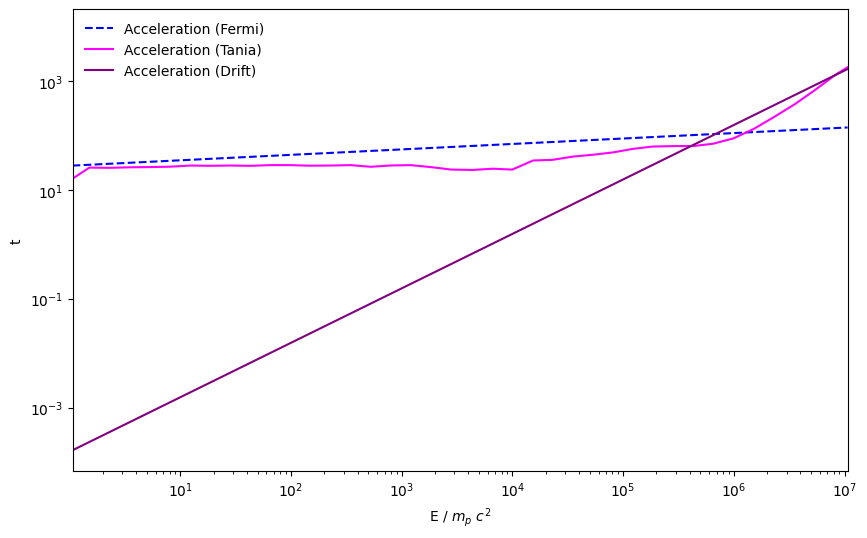

In [42]:
## erg

plt.figure(figsize=(10, 6))

plt.loglog(E_norm,timeacc_fermi(E_norm),'--',label='Acceleration (Fermi)',color='blue')
# plt.loglog(E_norm,time_acc_regime3(va, delta_RX),'--',label='Acceleration (Regime 3)',color='green')
plt.loglog(Eacc,tacc,label='Acceleration (Tania)',color='magenta')
plt.loglog(E_norm,timeacc_drift(E_norm, B_c, va),label='Acceleration (Drift)',color='purple')

plt.xlim((E_norm.min(),E_norm.max()))
plt.legend(frameon=False)
plt.xlabel('E / $m_p$ $c^2$')
plt.ylabel('t')
# plt.ylim((1e-4,1e4))
# plt.xticks([1e-2,1e-1,1e0,1e1,1e2,1e3],labels=['-2','-1','0','1','2','3'])
# plt.savefig('plots/cooling_hadrons_erg.png',dpi=300)

plt.show()